# Direct Detection of Dark Matter

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve

MeV  = 1.
m    = 1.
s    = 1.

eV   = 1e-6*MeV
keV  = 1e3*eV
GeV  = 1e9*eV
kg   = (1.78e-36)**-1*eV
g    = 1e-3*kg
amu  = 931.494*MeV  # atomic mass unit

yr   = 365*24*60*60*s
cm   = 1e-2*m
km   = 1e3*m

c    = 3e8*m/s

# atomic mass number of Xe
A_Xe = 131.293
# molar mass of Xe
M_Xe = A_Xe*g
# atomic mass of Xe
m_Xe = A_Xe*amu
# bulk mass of Xe detector
m_Xe_bulk = 500*kg
# Avogadro constant
N_A  = 6.02214086e23
# minimum recoil energy for detection
E_R_low = 3*keV
# proton mass
m_p = 938.272*MeV
# experiment duration
t_obs = 1*yr
# dark matter most probable velocity
v_0 = 220*km/s
# dark matter average velocity
v_av = 2*v_0/np.sqrt(np.pi)
# dark matter local density
rho_DM = 0.3*GeV/cm**3

## Functions

In [2]:
def mu(m_DM):
    """
    Returns the reduced mass of the system of colliding particles
    """
    return m_DM*m_Xe/(m_DM + m_Xe)


#calculate WIMP-Xenon coupling cross-section
def sigma_DM(m_DM, sigma_SI):
    """
    Returns cross-section for WIMP-Xenon interactions
    """
    return sigma_SI*(mu(m_DM)**2*A_Xe**2)/(m_p**2)


#calculate 0-order interation rate:
def R_0(m_DM, sigma):
    """
    Returns 0th-order interaction rate
    """
    return (N_A)/(M_Xe)*(rho_DM/m_DM)*sigma*v_av


def dRdE_R(E_R, m_DM, sigma):
    """
    Returns differential interaction rate
    """
    R_0_const = R_0(m_DM,sigma)
    E_0 = (1/2)*m_DM*(v_0/c)**2
    r = 4*mu(m_DM)**2/(m_DM*m_Xe)
    exponent = -E_R/(r*E_0)
    return (R_0_const/(r*E_0))*np.exp(exponent)
    

def N_events(m_DM, sigma_SI, E_R_low, E_R_upp):
    """
    Calculates expected number of events for specific detector mass
    and observation time
    """
    sigma_const = sigma_DM(m_DM, sigma_SI)
    R = quad(dRdE_R, E_R_low, E_R_upp, args=(m_DM, sigma_const,))
    return R[0]*m_Xe_bulk*t_obs


def sigma_SI_solver(m_DM):
    """
    For a certain WIMP mass, returns cross-section necessary for detection of 3
    events per year
    """
    equation = lambda sigma_SI: N_events(m_DM, sigma_SI, E_R_low, np.inf)-3.
    guess = 1e-46*cm**2
    return fsolve(equation, guess)

def chi_squared(m_DM, sigma_SI):
    """
    Returns chi-squared function for
    N_1 detections in the [E_R_1_low, E_R_1_upp] range and
    N_2 detections in the [E_R_2_low, E_R_2_upp] range
    """
    return (N_events(m_DM, sigma_SI, E_R_1_low, E_R_1_upp) - N_1)**2/N_1 +\
           (N_events(m_DM, sigma_SI, E_R_2_low, E_R_2_upp) - N_2)**2/N_2

## 95% C.L. upper limits on spin-independent WIMP-proton cross-section

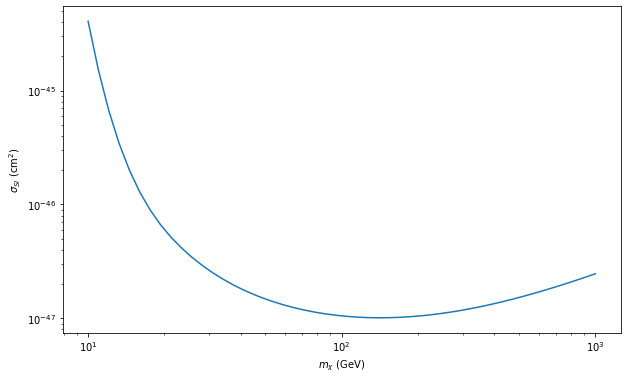

In [3]:
WIMP_mass_vect = np.logspace(1, 3)*GeV
sigma_SI_vect = []
for mass in WIMP_mass_vect:
    sigma_SI_vect.append(sigma_SI_solver(mass))
plt.figure(figsize=(10,6))
plt.plot(WIMP_mass_vect*GeV**-1, np.array(sigma_SI_vect)*cm**-2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\sigma_{SI}$ (cm$^2$)')
plt.xlabel(r'$m_\chi$ (GeV)')
plt.show()

## Reference plot of $\sigma_{SI}$ as a function of WIMP mass extracted from the 15th Patras Workshop on Axions, WIMPs and WISPs, June 2019

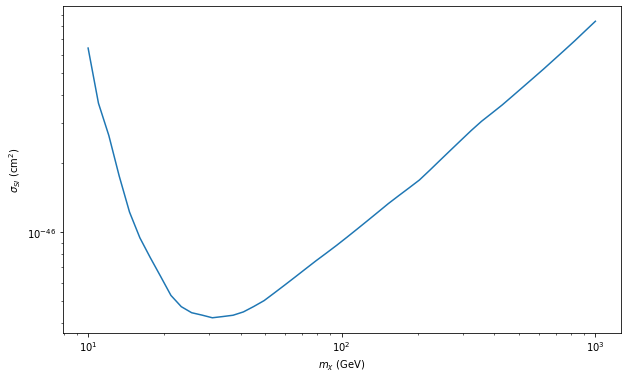

In [4]:
sigma_SI_data = np.genfromtxt('sigmaSI.csv', delimiter=',')
                             
sigma_SI=interp1d(sigma_SI_data[:,0]*GeV,sigma_SI_data[:,1]*cm**2,kind='linear',fill_value='extrapolate')
plt.figure(figsize=(10,6))
plt.plot(WIMP_mass_vect*GeV**-1, sigma_SI(WIMP_mass_vect)*cm**-2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\sigma_{SI}$ (cm$^2$)')
plt.xlabel(r'$m_\chi$ (GeV)')
plt.show()

## 68% and 95% confidence contours in the WIMP-proton coupling cross-section vs dark matter mass plane

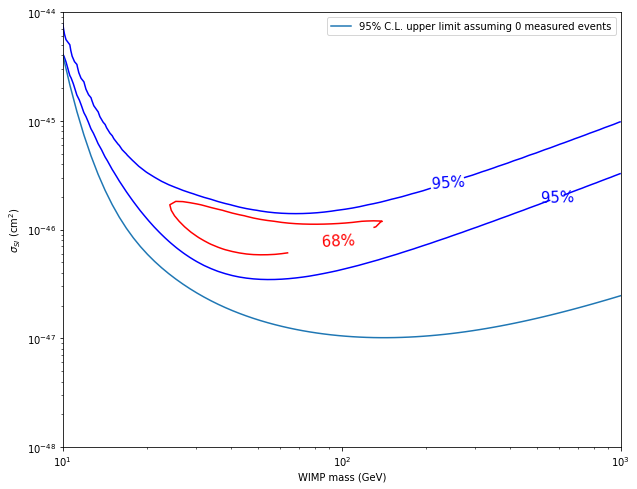

In [6]:
#lower bound of 1st recoil energy band
E_R_1_low = 3*keV
#upper bound of 1st recoil energy band
E_R_1_upp = 10*keV
#lower bound of 2nd recoil energy band
E_R_2_low = 10*keV
#upper bound of 2nd recoil energy band
E_R_2_upp = 20*keV
#number of different masses and cross-sections
resolution = 80


WIMP_mass_vect = np.logspace(1,3,resolution)*GeV
sigma_SI_vect = np.logspace(-48,-44,resolution)*cm**2

#number of measured events in the 1st energy band
N_1 = 10
#number of measured events in the 2nd energy band
N_2 = 5

chi_squared_array = np.zeros((resolution, resolution))
for i, mass in enumerate(WIMP_mass_vect):
    for j, sigma in enumerate(sigma_SI_vect):
        chi_squared_array[j,i] = chi_squared(mass, sigma)

levels = [2.28, 6]
fmt = {}
fmt[levels[0]] = "68%"
fmt[levels[1]] = "95%"

plt.figure(figsize=(10,8))
cont = plt.contour(WIMP_mass_vect/GeV, sigma_SI_vect/(cm**2), chi_squared_array, levels, colors=["red","blue"])
plt.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=15)
sigma_SI_vect = []
for mass in WIMP_mass_vect:
    sigma_SI_vect.append(sigma_SI_solver(mass)/(cm**2))
plt.plot(WIMP_mass_vect*GeV**-1, sigma_SI_vect, label="95% C.L. upper limit assuming 0 measured events")
plt.ylabel(r'$\sigma_{SI}$ (cm$^2$)')
plt.xlabel(r'WIMP mass (GeV)')
plt.legend()
plt.yscale('log')
plt.xscale('log')